In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import cv2 
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## 1.Dataset

Read the images from the folders, and create a CSV file with two columns: Image and Class.
This is done only once, so I can have one csv file to work with whenever I need it.

In [3]:
classes = ["Big_Ben", "Bradenburg_Gate", "Colosseo", "Duomo", "Eiffel", "Sagrada_familia",
           "Saint_Basil_Cathedral","Statue_of_liberty"]

In [4]:
df_dataset = pd.DataFrame(columns=["Image", "Class"])

In [5]:
Images_string = []
Labels = []

In [6]:
dataset_path = "\\card_dataset\\"

for i in range(0,len(classes)):
    dataset_path = dataset_path + classes[i] + "\\"
    for image in glob.glob(dataset_path + "*.jpg"):
        image_as_string = ""
        opened_image = cv2.imread(image, cv2.IMREAD_UNCHANGED)
        opened_image = opened_image.reshape(10000,)
        for j in opened_image:
            image_as_string = image_as_string + " " + str(j)
        Images_string.append(image_as_string)
        Labels.append(i)

In [7]:
df_dataset["Image"] = Images_string

In [8]:
df_dataset["Class"] = Labels

In [9]:
df_dataset

,Image,Class


In [ ]:
df_dataset.to_csv("card_dataset\individual_card_dataset.csv", index=False)

In [2]:
dataset = open("card_dataset\individual_card_dataset.csv", "r")
dataset.__next__()

'Image,Class\n'

In [3]:
(Images, Labels) = ([], [])
for row in dataset:
    image, label = row.strip().split(",")
    image = np.array(image.split(" "),dtype="float32")
    image = image.reshape((100,100))
    Images.append(image)
    Labels.append(int(label))

In [4]:
dataset.close()

In [5]:
trainFullImages, testImages, trainFullLabels, testLabels = train_test_split(Images, Labels, test_size=0.1, random_state=42)
trainImages, validationImages, trainLabels, validationLabels = train_test_split(trainFullImages, trainFullLabels, test_size=0.2, random_state=42)

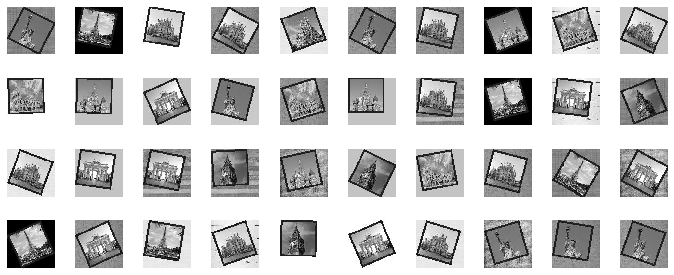

In [6]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(trainImages[index],cmap='gray', interpolation="nearest")
        plt.axis('off')
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [7]:
trainImages = np.asarray(trainImages) 
validationImages = np.asarray(validationImages)
testImages = np.asarray(testImages) / 255.0

trainLabels = np.asarray(trainLabels)
validationLabels = np.asarray(validationLabels)
testLabels = np.asarray(testLabels)

In [8]:
trainImages = trainImages[..., np.newaxis]
validationImages = validationImages[..., np.newaxis]
testImages = testImages[..., np.newaxis]

In [9]:
train_image_generator = keras.preprocessing.image.ImageDataGenerator(
                                          rescale = 1/255.0,
                                          zoom_range=[0.5,1.5],
                                          width_shift_range=.2,
                                          height_shift_range=.2,
                                          shear_range=.2,
                                          brightness_range=[0.3, 1.5])

In [10]:
validation_image_generator = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)

In [11]:
train_image_generator.fit(trainImages)
validation_image_generator.fit(validationImages)

# 2. Model (Pruned)

In [12]:
epochs = 20
batch_size = 64
num_train_samples = trainImages.shape[0]
end_step = np.ceil(1.0 * num_train_samples / batch_size).astype(np.int32) * epochs
print('End step: ' + str(end_step))

End step: 21380


In [13]:
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow import keras
from tensorflow.keras import layers
pruning_params = {
      'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.4,
                                                   final_sparsity=0.7,
                                                   begin_step=4000,
                                                   end_step=end_step,
                                                   frequency=500)
}

pruned_model = tf.keras.Sequential([
              sparsity.prune_low_magnitude(
                  layers.Conv2D(filters=64, input_shape=(100, 100, 1), kernel_size=(3,3), strides=(1,1), padding="same", kernel_initializer="he_normal"),
                  **pruning_params),
              layers.BatchNormalization(),
              layers.Activation(tf.nn.relu),
              layers.MaxPool2D(pool_size=2),
              sparsity.prune_low_magnitude(
                  layers.Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding="same", kernel_initializer="he_normal"),
                  **pruning_params),
              layers.BatchNormalization(),
              layers.Activation(tf.nn.relu),
              layers.MaxPool2D(pool_size=2),
              layers.Dropout(0.5),
              
              sparsity.prune_low_magnitude(
              layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding="same", kernel_initializer="he_normal"),
                  **pruning_params),
              layers.BatchNormalization(),
              layers.Activation(tf.nn.relu),
              layers.MaxPool2D(pool_size=2),
              sparsity.prune_low_magnitude(
              layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding="same", kernel_initializer="he_normal"),
                  **pruning_params),
              layers.BatchNormalization(),
              layers.Activation(tf.nn.relu),
              layers.MaxPool2D(pool_size=2),
              layers.Dropout(0.5),
                  
              layers.Flatten(),
              sparsity.prune_low_magnitude(
              layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
                  **pruning_params),
              layers.BatchNormalization(),
              layers.Dropout(0.5),
    
              sparsity.prune_low_magnitude(
              layers.Dense(units=128, activation="relu", kernel_initializer="he_normal"),
                  **pruning_params),
              layers.BatchNormalization(),
              layers.Dropout(0.5),
              
              sparsity.prune_low_magnitude(
              layers.Dense(units=8, activation="softmax", kernel_initializer="glorot_normal"),
                  **pruning_params)
              ])
pruned_model.summary()

Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv2d ( (None, 100, 100, 64)      1218      
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 100, 100, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
prune_low_magnitude_conv2d_1 (None, 50, 50, 64)        73794     
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 64)        256       
_________________________________________________

In [14]:
opt = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999,epsilon=1e-7)
pruned_model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='val_accuracy', mode='max',patience=5)
mc = ModelCheckpoint('pruned_card_classification_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)
s = sparsity.UpdatePruningStep()

In [16]:
history = pruned_model.fit_generator(train_image_generator.flow(trainImages, trainLabels, batch_size=batch_size),
                    steps_per_epoch=len(trainImages) // 64, epochs=epochs, validation_data=validation_image_generator.flow(validationImages, validationLabels),
                       callbacks=[es, mc, s])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1068 steps, validate for 535 steps
Epoch 1/20
1068/1068 [==============================] - 133s 125ms/step - loss: 1.3405 - accuracy: 0.5453 - val_loss: 3.4984 - val_accuracy: 0.3689
Epoch 2/20
1068/1068 [==============================] - 118s 111ms/step - loss: 0.2981 - accuracy: 0.9004 - val_loss: 0.6631 - val_accuracy: 0.7501
Epoch 3/20
1068/1068 [==============================] - 119s 111ms/step - loss: 0.1287 - accuracy: 0.9589 - val_loss: 2.1006 - val_accuracy: 0.5812
Epoch 4/20
1068/1068 [==============================] - 121s 113ms/step - loss: 0.0814 - accuracy: 0.9741 - val_loss: 0.8051 - val_accuracy: 0.7692
Epoch 5/20
1068/1068 [==============================] - 118s 111ms/step - loss: 0.0525 - accuracy: 0.9837 - val_loss: 0.2473 - val_accuracy: 0.9035
Epoch 6/20
1068/1068 [==============================] - 118s 111ms/step - loss: 0.0417 - 

In [17]:
score = pruned_model.evaluate(testImages, testLabels)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

9500/9500 [==============================] - 6s 610us/sample - loss: 0.1191 - accuracy: 0.9674
Test loss: 0.11912305417362797
Test accuracy: 0.9673684


In [18]:
final_model = sparsity.strip_pruning(pruned_model)
final_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 64)      640       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 100, 100, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 50, 50, 64)        0

In [19]:
tf.keras.models.save_model(final_model, 'card_model.h5')

In [20]:
new_model = tf.keras.models.load_model('card_model.h5')

In [21]:
opt = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999,epsilon=1e-7)
new_model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [22]:
new_model.evaluate(testImages, testLabels)


9500/9500 [==============================] - 5s 547us/sample - loss: 0.1191 - accuracy: 0.9674


[0.11912305417362797, 0.9673684]

## 3. Model Evaluation

### 3.1 Accuracy and Loss

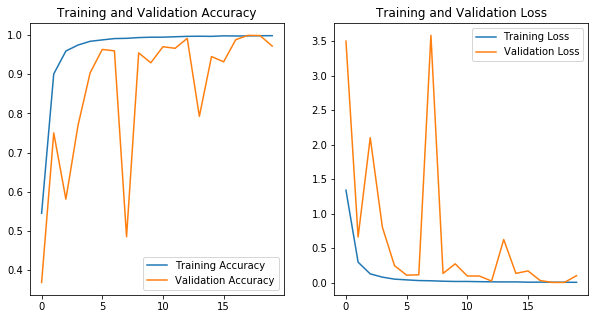

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 3.2 Confusion Matrix

In [30]:
y_pred = new_model.predict(testImages)
y_pred_c =np.argmax(y_pred, axis=1)

In [31]:
confusion_matrix = tf.math.confusion_matrix(testLabels, y_pred_c, num_classes=8)
confusion_matrix

<tf.Tensor: shape=(8, 8), dtype=int32, numpy=
array([[1151,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1143,    0,    0,    0,   36,    0,    0],
       [   0,    0, 1241,    0,    0,    0,    0,    0],
       [   0,    0,    0, 1201,    0,    7,    0,    0],
       [   0,    0,    0,    0, 1207,    0,    0,    0],
       [   0,    0,    0,    0,    0, 1153,    0,    0],
       [   0,    0,    0,    0,    0,  265,  964,    0],
       [   0,    0,    0,    0,    0,    2,    0, 1130]])>

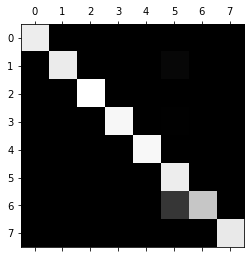

In [32]:
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

plt.matshow(confusion_matrix, cmap=plt.cm.gray)
plt.show()